# Authorship Attribution

Authorship analysis is, predominately, a text mining task that aims to identify certain aspects about an author, based only on the content of their writings. This could include characteristics such as age, gender, or background. In the specific authorship attribution task, we aim to identify who out of a set of authors wrote a particular document. This is a classic case of a classification task. In many ways, authorship analysis tasks are performed using standard data mining methodologies, such as cross fold validation, feature extraction, and classification algorithms.

In this chapter, we will use the problem of authorship attribution to piece together the parts of the data mining methodology we developed in the previous chapters. We identify the problem and discuss the background and knowledge of the problem. This lets us choose features to extract, which we will build a pipeline for achieving. We will test two different types of features: function words and character n-grams. Finally, we will perform an in-depth analysis of the results. We will work with a book dataset, and then a very messy real-world corpus of e-mails.

The topics we will cover in this chapter are as follows:
- Feature engineering and how the features differ based on application
- Revisiting the bag-of-words model with a specific goal in mind
- Feature types and the character n-grams model
- Support vector machines
- Cleaning up a messy dataset for data mining

## Attributing documents to authors
Authorship analysis has a background in stylometry, which is the study of an author's style of writing. The concept is based on the idea that everyone learns language slightly differently, and measuring the nuances in people's writing will enable us to tell them apart using only the content of their writing.

The problem has been historically performed using manual analysis and statistics, which is a good indication that it could be automated with data mining. Modern authorship analysis studies are almost entirely data mining-based, although quite a significant amount of work is still done with more manually driven analysis using linguistic styles.

Authorship analysis has many subproblems, and the main ones are as follows:
- **Authorship profiling**: This determines the age, gender, or other traits of the author based on the writing. For example, we can detect the first language of a person speaking English by looking for specific ways in which they speak the language.
- **Authorship verification**: This checks whether the author of this document also wrote the other document. This problem is what you would normally think about in a legal court setting. For instance, the suspect's writing style (content-wise) would be analyzed to see if it matched the ransom note.
- **Authorship clustering**: This is an extension of authorship verification, where we use cluster analysis to group documents from a big set into clusters, and each cluster is written by the same author.

However, the most common form of authorship analysis study is that of authorship attribution, a classification task where we attempt to predict which of a set of authors wrote a given document.

## Applications and use cases
Authorship analysis has a number of use cases. Many use cases are concerned withproblems such as verifying authorship, proving shared authorship/provenance, or linking social media profiles with real-world users.

Authorship studies alone cannot prove authorship, but can provide evidence for or against a given theory. For example, we can analyze Shakespeare's plays to determine his writing style, before testing whether a given sonnet actually does originate from him.

A more modern use case is that of linking social network accounts. For example, a malicious online user could set up accounts on multiple online social networks. Being able to link them allows authorities to track down the user of a given account—for example, if it is harassing other online users.

Authorship analysis is not foolproof though. A recent study found that attributingdocuments to authors can be made considerably harder by simply asking people, who are otherwise untrained, to hide their writing style. This study also looked at a framing exercise where people were asked to write in the style of another person. This framing of another person proved quite reliable, with the faked document commonly attributed to the person being framed.

## Attributing authorship
Authorship attribution is a classification task by which we have a set of candidate authors, a set of documents from each of those authors (the training set), and a set of documents of unknown authorship (the test set). If the documents of unknown authorship definitely belong to one of the candidates, we call this a **closed problem**.

If we cannot be sure of that, we call this an **open problem**. This distinction isn't just specific to authorship attribution though—any data mining application where the actual class may not be in the training set is considered an open problem, with the task being to find the candidate author or to select none of them.

The second restriction is that we don't look at the topic of the documents; instead, we look for more salient features such as word usage, punctuation, and other text-based features. The reasoning here is that a person can write on many different topics, so worrying about the topic of their writing isn't going to model their actual authorship style. Looking at topic words can also lead to overfitting on the training data—our model may train on documents from the same author and also on the same topic. For instance, if you were to model my authorship style by looking at this book, you might conclude the words data mining are indicative of my style, when in fact I write
on other topics as well.

## Getting the data

The data we will use for this chapter is a set of books from Project Gutenberg at www.gutenberg.org, which is a repository of public domain literature works.

The books I used for these experiments come from a variety of authors:
- Booth Tarkington
- Charles Dickens
- Edith Nesbit
- Arthur Conan Doyle
- Mark Twain
- Sir Richard Francis Burton
- Emile Gaboriau

A full list of the titles, along with download links and a script to automatically fetch them, is given in the code bundle. To download these books, we use the requests library to download the files into our data directory. First, set up the data directory and ensure the following code
links to it:

In [1]:
import csv
from collections import Counter
from io import BytesIO, StringIO
from pathlib import Path
import requests
import pandas as pd
import re
import os


In [ ]:
GUTENBERG_CSV_URL = "https://www.gutenberg.org/cache/epub/feeds/pg_catalog.csv.gz"

r = requests.get(GUTENBERG_CSV_URL)
csv_text = r.content.decode("utf-8")

print(f"Total size: {len(r.content) / 1024**2:0.2f}MB")
print(csv_text[:400])

Total size: 19.28MB
Text#,Type,Issued,Title,Language,Authors,Subjects,LoCC,Bookshelves
1,Text,1971-12-01,The Declaration of Independence of the United States of America,en,"Jefferson, Thomas, 1743-1826","United States -- History -- Revolution, 1775-1783 -- Sources; United States. Declaration of Independence",E201; JK,Politics; American Revolutionary War; United States Law; Browsing: History - American; Browsing: His


In [3]:
books_info = pd.DataFrame(csv.DictReader(StringIO(csv_text)))
books_info.head()

,Text#,Type,Issued,Title,Language,Authors,Subjects,LoCC,Bookshelves
0,1,Text,1971-12-01,The Declaration of Independence of the United ...,en,"Jefferson, Thomas, 1743-1826","United States -- History -- Revolution, 1775-1...",E201; JK,Politics; American Revolutionary War; United S...
1,2,Text,1972-12-01,The United States Bill of Rights\r\nThe Ten Or...,en,United States,Civil rights -- United States -- Sources; Unit...,JK; KF,Politics; American Revolutionary War; United S...
2,3,Text,1973-11-01,John F. Kennedy's Inaugural Address,en,"Kennedy, John F. (John Fitzgerald), 1917-1963",United States -- Foreign relations -- 1961-196...,E838,Browsing: History - American; Browsing: Politics
3,4,Text,1973-11-01,Lincoln's Gettysburg Address\r\nGiven November...,en,"Lincoln, Abraham, 1809-1865",Consecration of cemeteries -- Pennsylvania -- ...,E456,US Civil War; Browsing: History - American; Br...
4,5,Text,1975-12-01,The United States Constitution,en,United States,United States -- Politics and government -- 17...,JK; KF,United States; Politics; American Revolutionar...


In [4]:
books_info['Authors_parsed'] = books_info['Authors'].apply(lambda x:\
                                                        x.replace(',', '').\
                                                        replace('(', '').\
                                                        replace(')', ''))
rel_authors = ['Booth Tarkington', 'Charles Dickens', 'Edith Nesbit', 
    'Arthur Conan Doyle', 'Mark Twain', 'Sir Richard Francis Burton', 
    'Emile Gaboriau']

authors = [tuple(authors.split()) for authors in rel_authors]
authors

[('Booth', 'Tarkington'),
 ('Charles', 'Dickens'),
 ('Edith', 'Nesbit'),
 ('Arthur', 'Conan', 'Doyle'),
 ('Mark', 'Twain'),
 ('Sir', 'Richard', 'Francis', 'Burton'),
 ('Emile', 'Gaboriau')]

In [5]:
authors_to_check = books_info['Authors_parsed'].unique()
authors_to_check = [tuple(authors.split()) for authors in authors_to_check]
authors_to_check[:2]

[('Jefferson', 'Thomas', '1743-1826'), ('United', 'States')]

In [6]:
from collections import defaultdict

authors_to_keep = defaultdict(set)
authors_to_keep_for_df = []
for author_to_check in authors_to_check:
    for author in authors:
        if set(author).issubset(set(author_to_check)):
            authors_to_keep[author].add(' '.join(author_to_check))
            authors_to_keep_for_df.append( ' '.join(author_to_check))

In [7]:
books_for_training = books_info[books_info['Authors_parsed'].isin(authors_to_keep_for_df)]
book_id = books_for_training.iloc[1]["Text#"]

In [8]:
alternative_author_list = []
for author in authors_to_keep.keys():
    for alternative in authors_to_keep[author]:
        alternative_author_list.append([' '.join(author), alternative])
alternatives = pd.DataFrame(alternative_author_list, columns=['Alternative_names', 'Authors_parsed'])
books_for_training = pd.merge(books_for_training, alternatives, on='Authors_parsed')

In [9]:
books_for_training['Alternative_names'].value_counts(dropna=False)

Mark Twain                    257
Charles Dickens               207
Arthur Conan Doyle            156
Sir Richard Francis Burton     60
Edith Nesbit                   42
Emile Gaboriau                 34
Booth Tarkington               33
Name: Alternative_names, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split

_, books_for_training = train_test_split(books_for_training, test_size=.2, random_state=42)
books_for_training['Alternative_names'].value_counts(dropna=False)

Mark Twain                    47
Charles Dickens               39
Arthur Conan Doyle            38
Sir Richard Francis Burton    15
Edith Nesbit                   7
Emile Gaboriau                 6
Booth Tarkington               6
Name: Alternative_names, dtype: int64

In [11]:
GUTENBERG_ROBOT_URL = "http://www.gutenberg.org/robot/harvest?filetypes[]=txt"
r = requests.get(GUTENBERG_ROBOT_URL)
GUTENBERG_MIRROR = re.search('(https?://[^/]+)[^"]*.zip', r.text).group(1)

In [12]:
def gutenberg_text_urls(id, mirror=GUTENBERG_MIRROR, suffixes=("", "-8", "-0")):
    path = "/".join(id[:-1]) or "0"
    return [f"{mirror}/{path}/{id}/{id}{suffix}.zip" for suffix in suffixes]

gutenberg_text_urls(book_id)

['http://aleph.gutenberg.org/7/70/70.zip',
 'http://aleph.gutenberg.org/7/70/70-8.zip',
 'http://aleph.gutenberg.org/7/70/70-0.zip']

In [13]:
import logging
import zipfile

def download_gutenberg(id):
    for url in gutenberg_text_urls(id):
        r = requests.get(url)
        if r.status_code == 404:
            logging.warning(f"404 for {url}")
            continue
        r.raise_for_status()
        break
    try:
        z = zipfile.ZipFile(BytesIO(r.content))
        print(f'success with {id}')
    
        if len(z.namelist()) != 1:
            raise Exception(f"Expected 1 file in {z.namelist()}")
    except:
        print('file not a zip')
        return
        
    return z.read(z.namelist()[0]).decode('utf-8')

In [14]:
text = download_gutenberg(book_id)
print(text[:1500])

success with 70
﻿The Project Gutenberg eBook of What Is Man? And Other Stories, by Mark Twain (Samuel Clemens)

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this eBook or online at
www.gutenberg.org. If you are not located in the United States, you
will have to check the laws of the country where you are located before
using this eBook.

Title: What Is Man? And Other Stories

Author: Mark Twain (Samuel Clemens)

Release Date: June, 1993 [eBook #70]
[Most recently updated: May 26, 2022]

Language: English

Character set encoding: UTF-8

Produced by: An Anonymous Volunteer and David Widger

*** START OF THE PROJECT GUTENBERG EBOOK WHAT IS MAN? AND OTHER STORIES ***




WHAT IS MAN?
AND OTHER ESSAYS

By Mark Twain

(Samuel Langhorne Clemens, 1835-1910)


CONTENTS

 WHAT IS MAN

## Downloading all the files
Now we can download all the files in a simple loop; let’s create a simple function that gets and cleans the text:

In [16]:
GUTENBERG_TEXT = "PROJECT GUTENBERG EBOOK "

def strip_headers(text):
    in_text = False
    output = []
    
    for line in text.splitlines():        
        if GUTENBERG_TEXT in line:
            if not in_text:
                in_text = True
            else:
                break
        else:
            if in_text:
                output.append(line)

    return "\n".join(output).strip()

stripped_text = strip_headers(text)

In [ ]:
# GUTENBERG_TEXT_URL = "https://www.gutenberg.org/ebooks/{id}.txt.utf-8"


# def book_text(book_id):
#     r = requests.get(GUTENBERG_TEXT_URL.format(id=book_id))
#     text = r.text
#     clean_text = strip_headers(text)
#     return clean_text

# data_path = Path("data/author_texts")
# data_path.mkdir(exist_ok=True)

# count = 0
# for idx, book in books_for_training.iterrows():
#     if count%25 == 0:
#         print(f'finished {count}/{books_for_training.shape[0]}')
#     count += 1
#     id = book["Text#"]
#     text = book_text(id)
#     print(f"Saving {book['Title']} by {book['Authors_parsed']} containing {len(text):_} characters")
#     with open(data_path / (id + ".txt"), "wt") as f:
#         f.write(text)

finished 0/158
Saving New Treasure Seekers; Or, The Bastable Children in Search of a Fortune by Nesbit E. Edith 1858-1924 containing 367_421 characters
Saving 1601: Conversation as it was by the Social Fireside in the Time of the Tudors by Twain Mark 1835-1910 containing 67_227 characters
Saving Speeches: Literary and Social by Dickens Charles 1812-1870 containing 567_696 characters
Saving The Haunted Man and the Ghost's Bargain by Dickens Charles 1812-1870 containing 186_280 characters
Saving Doctor Marigold by Dickens Charles 1812-1870 containing 63_064 characters
Saving Mudfog and Other Sketches by Dickens Charles 1812-1870 containing 185_802 characters
Saving The Book of the Thousand Nights and a Night — Volume 16 by Burton Richard Francis Sir 1821-1890 [Translator] containing 945_509 characters
Saving The Parasite by Doyle Arthur Conan 1859-1930 containing 0 characters
Saving A Christmas Carol by Dickens Charles 1812-1870 containing 0 characters
Saving On the Decay of the Art of L

After taking a look at these files, you will see that many of them are quite messy—at least from a data analysis point of view. There is a large project Gutenberg disclaimer at the start of the files. This needs to be removed before we do our analysis.

We could alter the individual files on disk to remove this stuff. However, what happens if we were to lose our data? We would lose our changes and potentially be unable to replicate the study. For that reason, we will perform the preprocessing as we load the files—this allows us to be sure our results will be replicable (as long as the data source stays the same). The code is as follows:

In [18]:
data_folder = Path("data/author_texts")

In [181]:
import re

def clean_text(text):
    text = text.lower()
    text = ' '.join(re.sub(r'[^\w\s]', '', text).split())
    
    return text



In [182]:
def clean_book(document):
    lines = document.split("\n")
    start= 0
    end = len(lines)
    for i in range(len(lines)):
        line = lines[i]
        if line.startswith("*** START OF THIS PROJECT GUTENBERG"):
            start = i + 1
        elif line.startswith("*** END OF THIS PROJECT GUTENBERG"):
            end = i - 1
    fixed_lines = lines[start:end]
    res = []
    for lines in fixed_lines:
        res.append(clean_text(lines))
    return "\n".join(res)

In [ ]:
import glob

txt_files = glob.glob('data/author_texts/*.txt')
print("Text files:", txt_files)


Text files: ['data/author_texts/8473.txt', 'data/author_texts/65044.txt', 'data/author_texts/922.txt', 'data/author_texts/50162.txt', 'data/author_texts/5785.txt', 'data/author_texts/59813.txt', 'data/author_texts/24026.txt', 'data/author_texts/61751.txt', 'data/author_texts/102.txt', 'data/author_texts/9021.txt', 'data/author_texts/3450.txt', 'data/author_texts/50361.txt', 'data/author_texts/11301.txt', 'data/author_texts/7154.txt', 'data/author_texts/9743.txt', 'data/author_texts/53254.txt', 'data/author_texts/65043.txt', 'data/author_texts/5838.txt', 'data/author_texts/66991.txt', 'data/author_texts/66952.txt', 'data/author_texts/675.txt', 'data/author_texts/18718.txt', 'data/author_texts/3441.txt', 'data/author_texts/8528.txt', 'data/author_texts/61193.txt', 'data/author_texts/66159.txt', 'data/author_texts/50164.txt', 'data/author_texts/7157.txt', 'data/author_texts/51252.txt', 'data/author_texts/17398.txt', 'data/author_texts/139.txt', 'data/author_texts/5813.txt', 'data/author_t

In [184]:
# Import label encoder 
from sklearn import preprocessing 

label_encoder = preprocessing.LabelEncoder() 
books_for_training['Alternative_names_code']= label_encoder.fit_transform(books_for_training['Alternative_names']) 
  


In [185]:
import numpy as np

def load_books_data(folder=data_folder):
    documents = []
    authors = []
    subfolders = [subfolder for subfolder in glob.glob('data/author_texts/*.txt')]
    for _, subfolder in enumerate(subfolders):
        id = subfolder.split('/')[-1][:-4]
        class_val = int(books_for_training[books_for_training['Text#']==id]['Alternative_names_code'])
        with open(subfolder) as inf:
            documents.append(clean_book(inf.read()))
            authors.append(class_val)
    return documents, np.array(authors, dtype='int')

documents, classes = load_books_data(data_folder)
len(set(documents)), len(set(classes))

(136, 7)

## Function words
One of the earliest types of features, and one that still works quite well for authorship analysis, is to use function words in a bag-of-words model. Function words are words that have little meaning on their own, but are required for creating (English) sentences. For example, the words this and which are words that are really only defined by what they do within a sentence, rather than their meaning in themselves. Contrast this with a content word such as tiger, which has an explicit meaning and invokes imagery of a large cat when used in a sentence.

## Counting function words
We can count function words using the CountVectorizer class. This class can be passed a vocabulary, which is the set of words it will look for. If a vocabulary is not passed then it will learn this vocabulary from the dataset. All the words are in the training set of documents (depending on the other parameters of course).

First, we set up our vocabulary of function words, which is just a list containing each of them. Exactly which words are function words and which are not is up for debate.

In [189]:
function_words = ["a", "able", "aboard", "about", "above", "absent",
                  "according" , "accordingly", "across", "after", "against",
                  "ahead", "albeit", "all", "along", "alongside", "although",
                  "am", "amid", "amidst", "among", "amongst", "amount", "an",
                    "and", "another", "anti", "any", "anybody", "anyone",
                    "anything", "are", "around", "as", "aside", "astraddle",
                    "astride", "at", "away", "bar", "barring", "be", "because",
                    "been", "before", "behind", "being", "below", "beneath",
                    "beside", "besides", "better", "between", "beyond", "bit",
                    "both", "but", "by", "can", "certain", "circa", "close",
                    "concerning", "consequently", "considering", "could",
                    "couple", "dare", "deal", "despite", "down", "due", "during",
                    "each", "eight", "eighth", "either", "enough", "every",
                    "everybody", "everyone", "everything", "except", "excepting",
                    "excluding", "failing", "few", "fewer", "fifth", "first",
                    "five", "following", "for", "four", "fourth", "from", "front",
                    "given", "good", "great", "had", "half", "have", "he",
                    "heaps", "hence", "her", "hers", "herself", "him", "himself",
                    "his", "however", "i", "if", "in", "including", "inside",
                    "instead", "into", "is", "it", "its", "itself", "keeping",
                    "lack", "less", "like", "little", "loads", "lots", "majority",
                    "many", "masses", "may", "me", "might", "mine", "minority",
                    "minus", "more", "most", "much", "must", "my", "myself",
                    "near", "need", "neither", "nevertheless", "next", "nine",
                    "ninth", "no", "nobody", "none", "nor", "nothing",
                    "notwithstanding", "number", "numbers", "of", "off", "on",
                    "once", "one", "onto", "opposite", "or", "other", "ought",
                    "our", "ours", "ourselves", "out", "outside", "over", "part",
                    "past", "pending", "per", "pertaining", "place", "plenty",
                    "plethora", "plus", "quantities", "quantity", "quarter",
                    "regarding", "remainder", "respecting", "rest", "round",
                    "save", "saving", "second", "seven", "seventh", "several",
                    "shall", "she", "should", "similar", "since", "six", "sixth",
                    "so", "some", "somebody", "someone", "something", "spite",
                    "such", "ten", "tenth", "than", "thanks", "that", "the",
                    "their", "theirs", "them", "themselves", "then", "thence",
                    "therefore", "these", "they", "third", "this", "those",
                    "though", "three", "through", "throughout", "thru", "thus",
                    "till", "time", "to", "tons", "top", "toward", "towards",
                    "two", "under", "underneath", "unless", "unlike", "until",
                    "unto", "up", "upon", "us", "used", "various", "versus",
                    "via", "view", "wanting", "was", "we", "were", "what",
                    "whatever", "when", "whenever", "where", "whereas",
                    "wherever", "whether", "which", "whichever", "while",
                    "whilst", "who", "whoever", "whole", "whom", "whomever",
                    "whose", "will", "with", "within", "without", "would", "yet",
                    "you", "your", "yours", "yourself", "yourselves"]

Now, we can set up an extractor to get the counts of these function words. We will fit this using a pipeline later:

In [190]:
from sklearn.feature_extraction.text import CountVectorizer
extractor = CountVectorizer(vocabulary=function_words)

## Classifying with function words
Next, we import our classes. The only new thing here is the support vector machines, which we will cover in the next section (for now, just consider it a standard classification algorithm). We import the SVC class, an SVM for classification, as well as the other standard workflow tools we have seen before:

In [191]:

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

Support vector machines take a number of parameters. We will use one blindly here, before going into detail in the next section. We then use a dictionary to set which parameters we are going to search. For the `kernel` parameter, we will try `linear` and `rbf`. For `C`, we will try values of 1 and 10 (descriptions of these parameters are covered in the next section). We then create a grid search to search these parameters for the best choices:

In [192]:

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = SVC()
grid = GridSearchCV(svr, parameters, cv=3)

In [193]:
pipeline1 = Pipeline([('feature_extraction', extractor),
                      ('clf', grid)])

In [194]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer,f1_score

f1_scorer = make_scorer(f1_score, average='weighted')
scores = cross_val_score(pipeline1, documents, classes, scoring=f1_scorer)

print(np.mean(scores))

0.468445884009698


## Support vector machines
**Support vector machines (SVMs)** are classification algorithms based on a simple and intuitive idea. It performs classification between only two classes (although we can extend it to more classes). Suppose that our two classes can be separated by a line such that any points above the line belong to one class and any below the line belong to the other class. SVMs find this line and use it for prediction, much the same way as linear regression works. SVMs, however, find the best line for separating the dataset. In the following figure, we have three lines that separate the dataset: blue, black, and green. Which would you say is the best option?

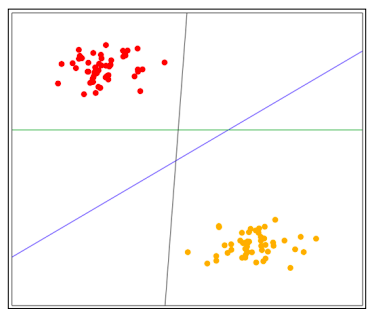

Intuitively, a person would normally choose the blue line as the best option, as this separates the data the most. That is, it has the maximum distance from any point in each class. Finding this line is an optimization problem, based on finding the lines of margin with the maximum distance between them.

## Classifying with SVMs
After training the model, we have a line of maximum margin. The classification of new samples is then simply asking the question: does it fall above the line, or below it? If it falls above the line, it is predicted as one class. If it is below the line, it is
predicted as the other class.

For multiple classes, we create multiple SVMs—each a binary classifier. We then connect them using any one of a variety of strategies. A basic strategy is to create a **one-versus-all** classifier for each class, where we train using two classes—the given
class and all other samples. We do this for each class and run each classifier on a new sample, choosing the best match from each of these. This process is performed automatically in most SVM implementations.

We saw two parameters in our previous code: `C` and the `kernel`. We will cover the kernel parameter in the next section, but the C parameter is an important parameter for fitting SVMs. The C parameter relates to how much the classifier should aim to predict all training samples correctly, at the risk of overfitting. Selecting a higher C value will find a line of separation with a smaller margin, aiming to classify all training samples correctly. Choosing a lower C value will result in a line of separation with a larger margin—even if that means that some training samples are incorrectly classified. In this case, a lower C value presents a lower chance of overfitting, at the risk of choosing a generally poorer line of separation.

One limitation with SVMs (in their basic form) is that they only separate data that is linearly separable. What happens if the data isn't? For that problem, we use kernels.

## Kernels
When the data cannot be separated linearly, the trick is to embed it onto a higher dimensional space. What this means is to add pseudo-features until the data is linearly separable (which will always happen if you add enough of the right kinds of features).

The trick is that we often compute the inner-produce of the samples when finding the best line to separate the dataset. Given a function that uses the dot product, we effectively manufacture new features without having to actually define those new features. This is handy because we don't know what those features were going to be anyway. We now define a kernel as a function that itself is the dot product of the function of two samples from the dataset, rather than based on the samples (and the made-up features) themselves.

We can now compute what that dot product is (or approximate it) and then just use that.

There are a number of kernels in common use. The linear kernel is the most straightforward and is simply the dot product of the two sample feature vectors, the weight feature, and a bias value. There is also a polynomial kernel, which raises the dot product to a given degree (for instance, 2). Others include the Gaussian (rbf) and Sigmoidal functions. In our previous code sample, we tested between the linear kernel and the rbf kernels.

## Character n-grams
We saw how function words can be used as features to predict the author of a document. Another feature type is **character n-grams**. An n-gram is a sequence of n objects, where n is a value (for text, generally between 2 and 6). Word n-grams have been used in many studies, usually relating to the topic of the documents. However, character n-grams have proven to be of high quality for authorship attribution.

Character n-grams are found in text documents by representing the document as a sequence of characters. These n-grams are then extracted from this sequence and a model is trained. There are a number of different models for this, but a standard one is very similar to the bag-of-words model we have used earlier.

For each distinct n-gram in the training corpus, we create a feature for it. An example of an n-gram is <e t>, which is the letter e, a space, and then the letter t (the angle brackets are used to denote the start and end of the n-gram and aren't part of it). We
then train our model using the frequency of each n-gram in the training documents and train the classifier using the created feature matrix.

A common theory for why character n-grams work is that people more typically write words they can easily say and character n-grams (at least when n is between 2 and 6) are a good approximation for phonemes—the sounds we make when saying words. In this sense, using character n-grams approximates the sounds of words, which approximates your writing style. This is a common pattern when creating
new features. First we have a theory on what concepts will impact the end result (authorship style) and then create features to approximate or measure those concepts.

A main feature of a character n-gram matrix is that it is sparse and increases in sparsity with higher n-values quite quickly. For an n-value of 2, approximately 75 percent of our feature matrix is zeros. For an n-value of 5, over 93 percent is zeros. This is typically less sparse than a word n-gram matrix of the same type though and shouldn't cause many issues using a classifier that is used for word-based classifications.

## Extracting character n-grams
We are going to use our CountVectorizer class to extract character n-grams. To do that, we set the analyzer parameter and specify a value for n to extract n-grams with.

The implementation in scikit-learn uses an n-gram range, allowing you to extract n-grams of multiple sizes at the same time. We won't delve into different n-values in this experiment, so we just set the values the same. To extract n-grams of size 3, you need to specify (3, 3) as the value for the n-gram range.

We can reuse the grid search from our previous code. All we need to do is specify the new feature extractor in a new pipeline:

In [195]:
pipeline = Pipeline([('feature_extraction', 
                      CountVectorizer(analyzer='char', 
                                      ngram_range=(3, 3))),
                     ('classifier', grid)])
scores = cross_val_score(pipeline, 
                         documents, 
                         classes, 
                         scoring=f1_scorer)
print(f"Score: {np.mean(scores):.3f}")

Score: 0.609


**Note:** There is a lot of implicit overlap between function words and character n-grams, as character sequences in function words are more likely to appear. However, the actual features are very different and character n-grams capture punctuation, which function words do not. For example, a character n-gram includes the full stop at the end of a sentence, while a function word-based method would only use the preceding word itself.